# Analysis

In [1]:
# ruff: noqa
%reload_ext autoreload
%autoreload 2

# Standard imports
import os
import json

# External imports
import hydra
import rootutils
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from wandb.sdk.wandb_run import Run

import wandb

In [2]:
# Reinitialize hydra on every run
hydra.core.global_hydra.GlobalHydra.instance().clear()
h = hydra.initialize(config_path="../conf", job_name="eda", version_base=None)

# Setup root environment
root_path = rootutils.setup_root(".")
rootutils.set_root(
    path=root_path,
    project_root_env_var=True,
)

In [3]:
# Global paths
ROOT_DIR = root_path
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "report", "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

In [4]:
# Global Labeling
rename_dict = {
    "human": "Human",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "context1": "Context 1",
    "context2": "Context 2",
    "context3": "Context 3",
    "zeroshot": "0-shot",
    "oneshot": "1-shot",
    "f1": "Macro F1",
    "acc": "Acc",
    "precision": "Precision",
    "recall": "Recall",
    "lpp": "Labels Per Page",
}

def rename(x):
    return rename_dict.get(x, x)

def get_labeler_name(name: str):
    return " + ".join([rename_dict.get(n, n) for n in name.split("-")])

def get_metric_name(name: str):
    if "/" in name:
        split, metric = name.split("/")
        return f"{rename_dict.get(split, split)} {rename_dict.get(metric, metric)}"
    else:
        return rename_dict.get(name, name)

In [5]:
# Load categories
with open(os.path.join("..", "data", "meta", "categories.json"), "r") as f:
    categories_and_desc = json.load(f)

categories, categories_desc = zip(*categories_and_desc.items())
idx2categories = dict(enumerate(categories))

In [6]:
# Style and colors
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [7]:
# Initialise W&B
# Initialize wandb
WANDB_PROJECT = "homepage2vec"
WANDB_ENTITY = "ml-project-2-mlp"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
print(f"✅ Loaded {len(runs)} runs from W&B ({WANDB_ENTITY}/{WANDB_PROJECT})")

✅ Loaded 241 runs from W&B (ml-project-2-mlp/homepage2vec)


In [8]:
# Helpers
def extract_config(run: Run) -> dict:
    """
    Extracts the config from a run.
    """
    data_attr = ["name"]
    labeler_attr = ["name", "model", "fewshot", "features"]
    train_data = {f"train_data_{k}":v for k,v  in run.config.get("train_data", {}).items() if k in data_attr}
    test_data = {f"test_data_{k}":v for k,v  in run.config.get("test_data", {}).items() if k in data_attr}
    train_labeler = {f"train_labeler_{k}":v for k,v  in run.config.get("train_labeler", {}).items() if k in labeler_attr}
    test_labeler = {f"test_labeler_{k}":v for k,v  in run.config.get("test_labeler", {}).items() if k in labeler_attr}
    train_ratio = run.config.get("train_datamodule", {}).get("data_split", [None])[0]
    val_ratio, test_ratio = run.config.get("test_datamodule", {}).get("data_split", [None, None, None])[1:]

    config = {"id": run.id, "name": run.name, "finetune": run.config["finetune"], "train_ratio": train_ratio, "val_ratio": val_ratio, "test_ratio": test_ratio, **train_data, **test_data, **train_labeler, **test_labeler}

    return config

def extract_hparams(run: Run) -> dict:
    """
    Extracts the hparams from a run.
    """
    hparams = {
        "lr": run.config.get("model", {}).get("optimizer", {}).get("lr", None),
        "weight_decay": run.config.get("model", {}).get("optimizer", {}).get("weight_decay", None),
        "scheduler_factor": run.config.get("model", {}).get("scheduler", {}).get("factor", None),
        "batch_size": run.config.get("datamodule", {}).get("batch_size", None),
    }
    return hparams

def extract_summary(run: Run, exclude:list[str] = ["test/cm", "test/report"]) -> dict:
    """
    Extracts the summary from a run.
    """
    summary = {k:v for k, v in run.summary.items() if not k.startswith("_") and k not in exclude}
    return summary

def runs_to_df(runs: list[Run]) -> pd.DataFrame:
    """
    Convert a list of W&B runs to a dataframe.
    """
    # Extract information from runs
    rows = []
    for run in runs[::-1]:
        config = extract_config(run)
        hparams = extract_hparams(run)
        summary = extract_summary(run)
        rows.append({**config, **hparams, **summary})

    # Add multi-index
    columns = list(config.keys()) + list(hparams.keys()) + list(summary.keys())
    config_tuples = [("config", k) for k in config.keys()]
    hparams_tuples = [("hparams", k) for k in hparams.keys()]
    summary_tuples = [("summary", k) for k in summary.keys()]

    # Create dataframe
    run_df = pd.DataFrame(rows, columns=columns)
    run_df.columns = pd.MultiIndex.from_tuples(
        config_tuples + hparams_tuples + summary_tuples,
    )
    run_df.set_index(("config", "id"), inplace=True)

    return run_df

In [9]:
def best_runs(df_runs: pd.DataFrame, split: str="val", metric: str="f1") -> pd.DataFrame:
    """
    Get the best runs based on the validation metric for 
    each unique combination of data, labeler - specified 
    in the run name.

    Args:
        df_runs (pd.DataFrame): Dataframe of runs.
        metric (str): Metric to sort on.

    Returns:
        pd.DataFrame: Dataframe of best runs.
    """
    experiment_cols = [("config", "train_labeler_name"), ("config", "finetune")]
    unique_exps = df_runs[experiment_cols].drop_duplicates()
    best_runs = []
    for unique_exp in unique_exps.values:
        is_unique_exp = (df_runs[experiment_cols] == unique_exp).all(axis=1)
        best_exp_run = df_runs[is_unique_exp].sort_values(("summary", f"{split}/{metric}"), ascending=False).iloc[0]
        best_runs.append(best_exp_run)

    return pd.DataFrame(best_runs)

## Experiment 1: Fine-tuning on `original`

---

In this experiment we are verifying the annotation quality of the various `labelers` (specified in `conf/labelers`) by fine-tuning models on the `original` dataset with the labels provided by each labeler. The training parameters are kept constant for all the experiments.

In [10]:
# Filter runs for Experiment 1
GROUP = "exp1"

exp1_runs = [run for run in runs if run.group == GROUP]

print(f"✅ Loaded {len(exp1_runs)} runs from W&B ({WANDB_ENTITY}/{WANDB_PROJECT} - {GROUP})")

✅ Loaded 173 runs from W&B (ml-project-2-mlp/homepage2vec - exp1)


In [11]:
# Convert to dataframe
exp1_runs_df = runs_to_df(exp1_runs)

exp1_runs_df

config                                            \
                             name finetune train_ratio val_ratio test_ratio   
(config, id)                                                                  
h80hilbf       revived-forest-130    False         0.6       0.1        0.3   
tpiip288           glad-water-132     True         0.6       0.1        0.3   
pjo7al0c           lemon-wood-134     True         0.6       0.1        0.3   
9ox1xym4        playful-night-135     True         0.6       0.1        0.3   
1y6remf2           cool-field-136     True         0.6       0.1        0.3   
...                           ...      ...         ...       ...        ...   
3gdn3uh0         revived-bush-336     True         0.6       0.1        0.3   
69p5ufyh      serene-snowball-337     True         0.6       0.1        0.3   
uon6cf0t            rich-bird-338     True         0.6       0.1        0.3   
w18l4zoh           denim-lion-339     True         0.6       0.1        0.3   
fb53pom1        icy-snowflake-340     True         0.6       0.1        0.3   

                                                                    \
             train_data_name test_data_name     train_labeler_name   
(config, id)                                                         
h80hilbf            original       original                  human   
tpiip288            original       original                  human   
pjo7al0c            original       original                  human   
9ox1xym4            original       original                  human   
1y6remf2            original       original                  human   
...                      ...            ...                    ...   
3gdn3uh0            original       original  gpt4-oneshot-context2   
69p5ufyh            original       original  gpt4-oneshot-context2   
uon6cf0t            original       original  gpt4-oneshot-context2   
w18l4zoh            original       original  gpt4-oneshot-context2   
fb53pom1            original       original  gpt4-oneshot-context2   

                                 hparams  ...   summary            \
             test_labeler_name        lr  ...  test/lpp train/acc   
(config, id)                              ...                       
h80hilbf                 human  0.000100  ...  2.279476       NaN   
tpiip288                 human  0.003752  ...  1.558952  0.412124   
pjo7al0c                 human  0.000590  ...  2.161572  0.830357   
9ox1xym4                 human  0.008326  ...  1.379913  0.831140   
1y6remf2                 human  0.004325  ...  1.851528  0.839912   
...                        ...       ...  ...       ...       ...   
3gdn3uh0                 human  0.003293  ...  2.126637  0.872964   
69p5ufyh                 human  0.000476  ...  2.017467  0.907112   
uon6cf0t                 human  0.005904  ...  2.187773  0.853383   
w18l4zoh                 human  0.003023  ...  1.938865  0.851660   
fb53pom1                 human  0.001668  ...  2.537118  0.955044   

                                                                       \
                                                     test/preds epoch   
(config, id)                                                            
h80hilbf      [[1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1], [...   0.0   
tpiip288      [[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1], [...  21.0   
pjo7al0c      [[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  24.0   
9ox1xym4      [[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  22.0   
1y6remf2      [[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [...  21.0   
...                                                         ...   ...   
3gdn3uh0      [[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  21.0   
69p5ufyh      [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [...  48.0   
uon6cf0t      [[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  22.0   
w18l4zoh      [[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [...  23.0   
fb53pom1      [[1, 1, 0

In [12]:
exp1_best_runs_df = best_runs(exp1_runs_df)

# Show best runs by F1
exp1_best_runs_df.sort_values(("summary", "test/f1"), ascending=False)

config                                            \
                            name finetune train_ratio val_ratio test_ratio   
69p5ufyh     serene-snowball-337     True         0.6       0.1        0.3   
h80hilbf      revived-forest-130    False         0.6       0.1        0.3   
783syce8         hopeful-eon-305     True         0.6       0.1        0.3   
j2h0426p         ancient-sea-140     True         0.6       0.1        0.3   
jxb1k2ms         wise-sponge-273     True         0.6       0.1        0.3   
8jh8ijjv  distinctive-breeze-317     True         0.6       0.1        0.3   
3my6opvf         ruby-breeze-216     True         0.6       0.1        0.3   
jq0bd869     distinctive-sun-243     True         0.6       0.1        0.3   
5oeblkjx  dazzling-butterfly-190     True         0.6       0.1        0.3   
ca5l4txn         warm-flower-166     True         0.6       0.1        0.3   

                                                                   \
         train_data_name test_data_name        train_labeler_name   
69p5ufyh        original       original     gpt4-oneshot-context2   
h80hilbf        original       original                     human   
783syce8        original       original   gpt3.5-oneshot-context3   
j2h0426p        original       original                     human   
jxb1k2ms        original       original  gpt3.5-zeroshot-context3   
8jh8ijjv        original       original    gpt4-zeroshot-context2   
3my6opvf        original       original  gpt3.5-zeroshot-context2   
jq0bd869        original       original   gpt3.5-oneshot-context2   
5oeblkjx        original       original   gpt3.5-oneshot-context1   
ca5l4txn        original       original  gpt3.5-zeroshot-context1   

                             hparams  ...   summary            \
         test_labeler_name        lr  ...  test/lpp train/acc   
69p5ufyh             human  0.000476  ...  2.017467  0.907112   
h80hilbf             human  0.000100  ...  2.279476       NaN   
783syce8             human  0.000477  ...  1.716157  0.917137   
j2h0426p             human  0.000155  ...  2.165939  0.820959   
jxb1k2ms             human  0.000160  ...  2.148472  0.849624   
8jh8ijjv             human  0.000215  ...  2.157205  0.865288   
3my6opvf             human  0.000215  ...  2.078603  0.854793   
jq0bd869             human  0.000215  ...  2.113537  0.857769   
5oeblkjx             human  0.000215  ...  2.135371  0.856360   
ca5l4txn             human  0.000215  ...  2.052402  0.860746   

                                                                             \
                                                 test/preds epoch   test/f1   
69p5ufyh  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [...  48.0  0.408944   
h80hilbf  [[1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1], [...   0.0  0.400624   
783syce8  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [...  51.0  0.389673   
j2h0426p  [[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  28.0  0.388535   
jxb1k2ms  [[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  38.0  0.386788   
8jh8ijjv  [[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  34.0  0.385217   
3my6opvf  [[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  42.0  0.384767   
jq0bd869  [[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  37.0  0.384687   
5oeblkjx  [[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  30.0  0.382931   
ca5l4txn  [[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [...  36.0  0.376917   

                                                                       \
           val/acc                                       test/targets   
69p5ufyh  0.820489  [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], [...   
h80hilbf       NaN  [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], [...   
783syce8  0.832707  [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], [...   
j2h0426p  0.806391  [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], [...   
jxb1k2ms  0.800752  [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], [...   
8jh8ijjv  0.798872 

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures


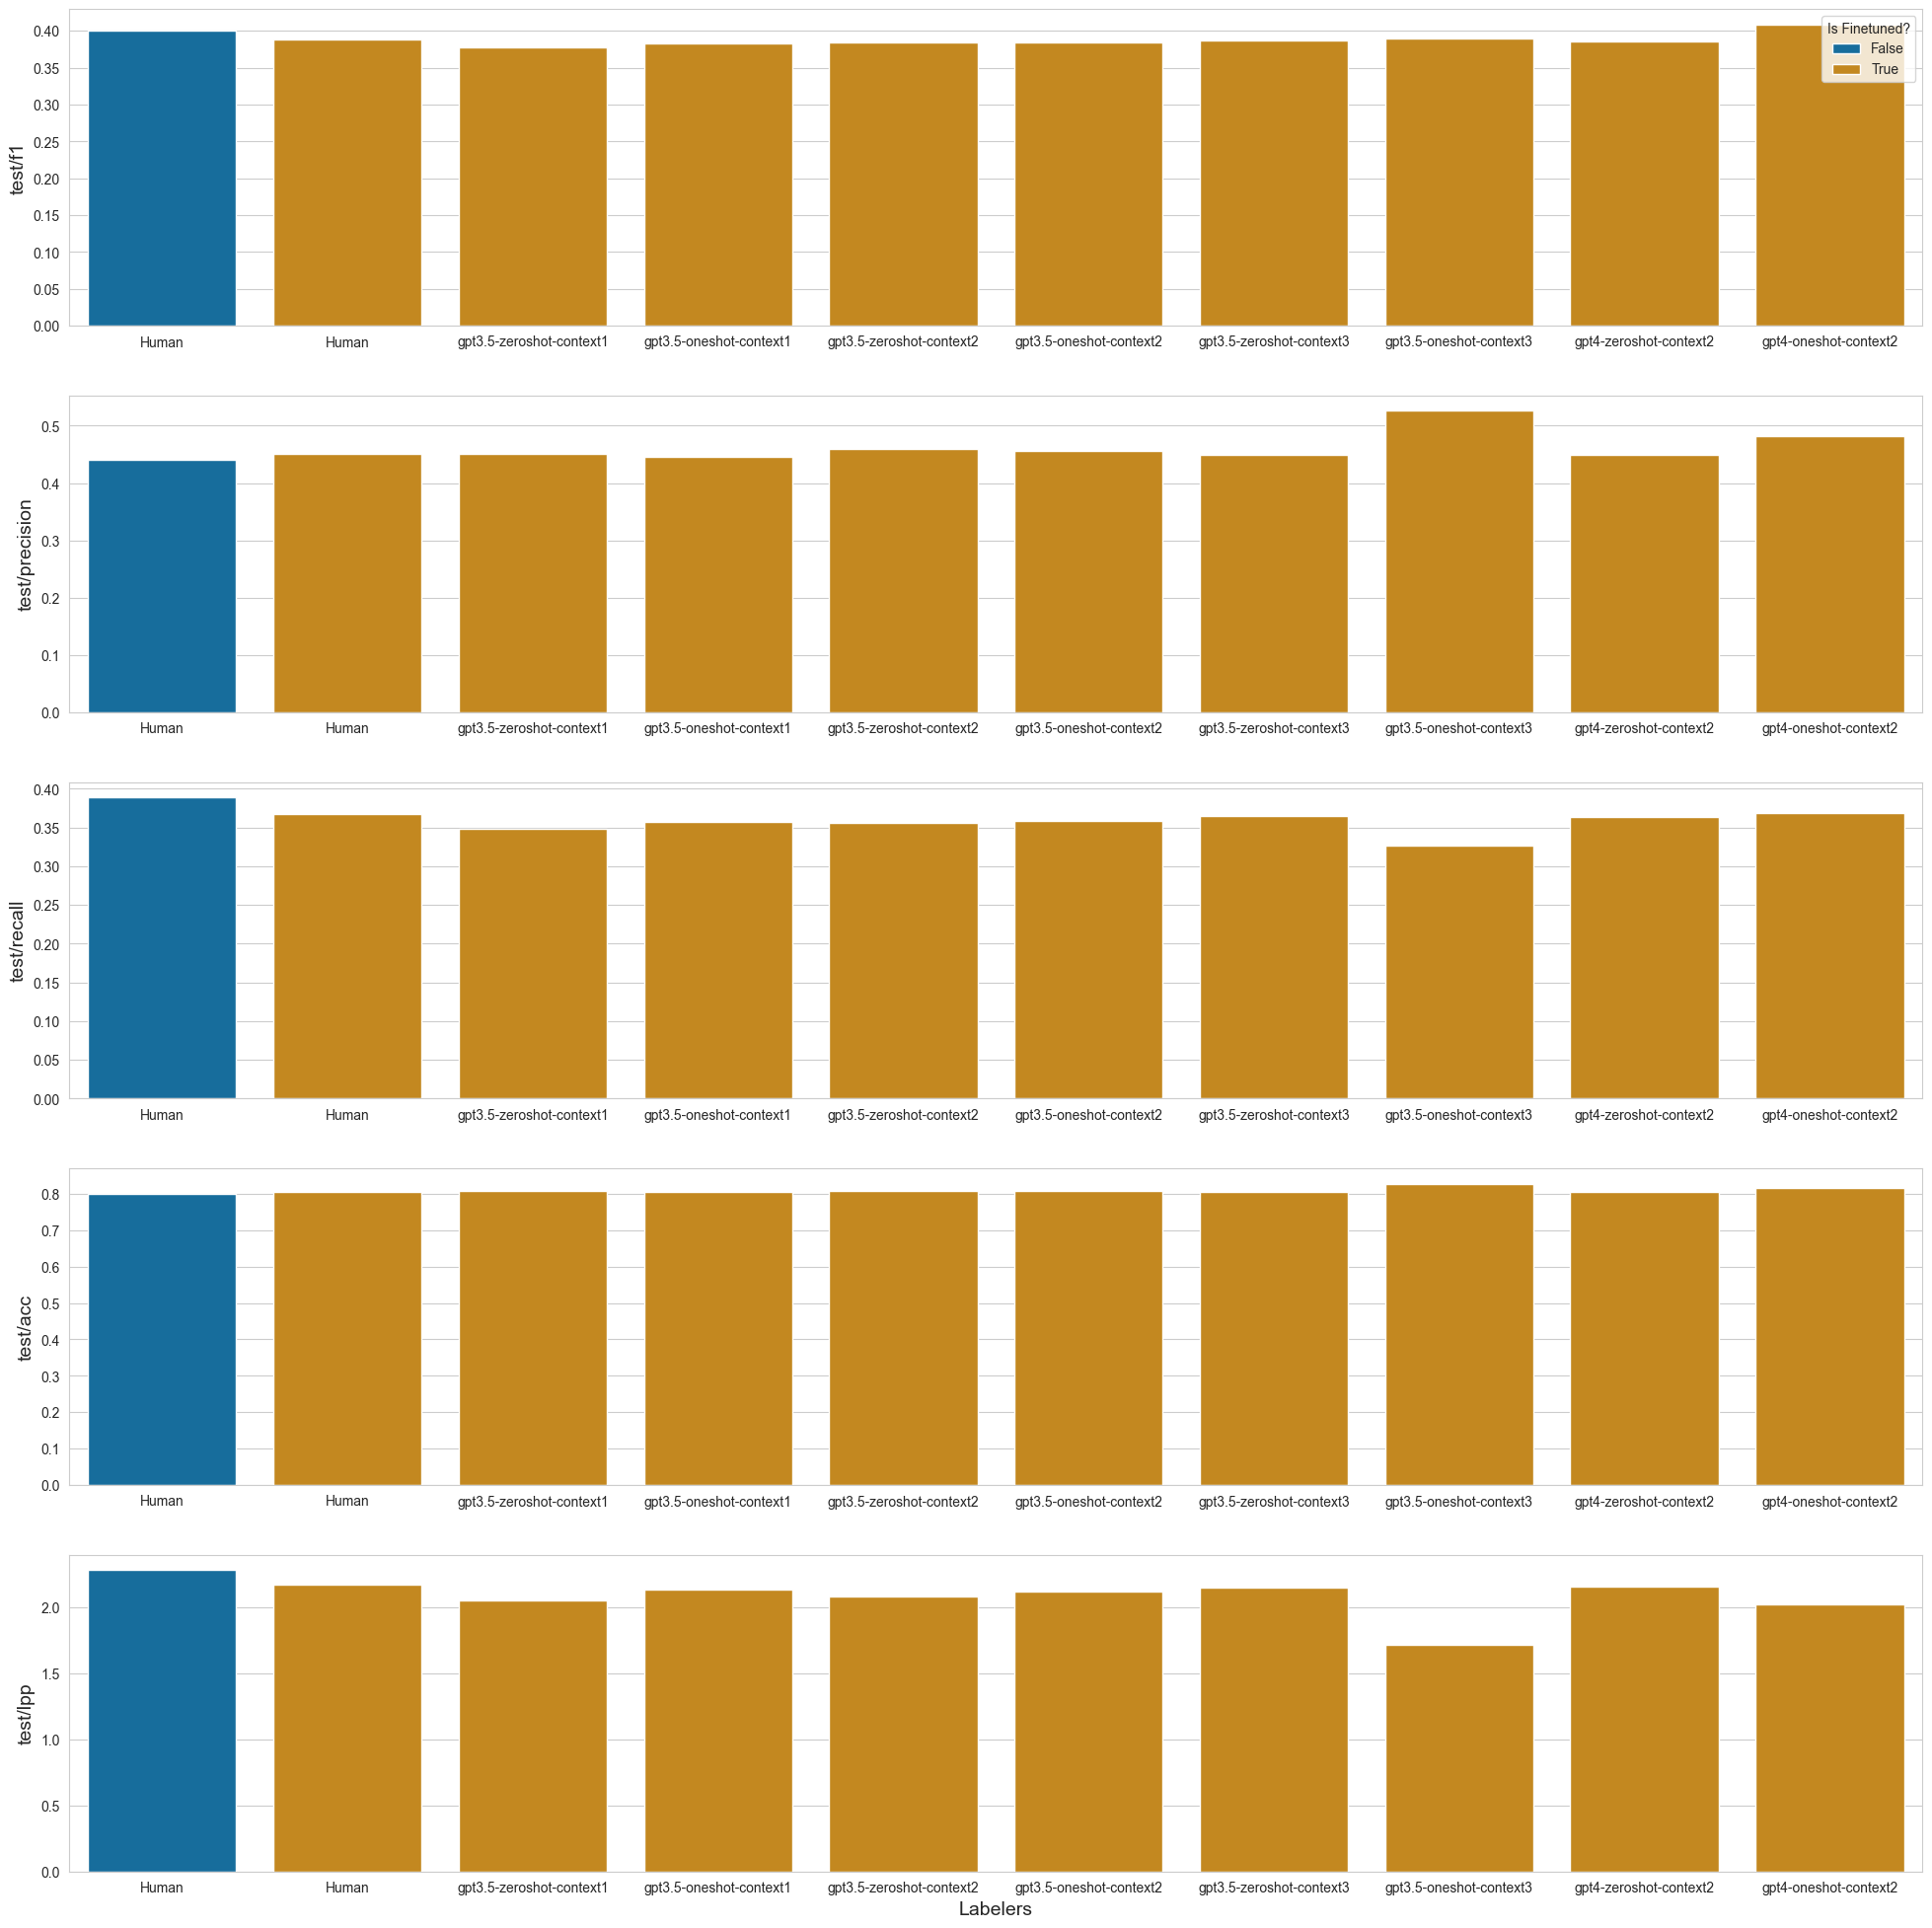

In [13]:
# Visualise best runs by metric
metrics = ["test/f1", "test/precision", "test/recall", "test/acc", "test/lpp"]
fig, axs = plt.subplots(nrows=5, figsize=(20, 20))
fig.tight_layout(pad=3.0)

for ax, metric in zip(axs, metrics):
    sns.barplot(
        data=exp1_best_runs_df,
        x=exp1_best_runs_df[("config", "name")],
        y=("summary", metric),
        hue=("config", "finetune"),
        ax=ax
    )
    ax.set_xticks(ax.get_xticks())
    run_names = [x.get_text() for x in ax.get_xticklabels()]
    rows = [exp1_best_runs_df[exp1_best_runs_df[("config", "name")] == run_name].iloc[0] for run_name in run_names]
    xtick_labels = [rename(row[("config", "train_labeler_name")]) for row in rows]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel("")
    ax.set_ylabel(rename(metric), fontsize=14)
    ax.get_legend().set_title("Is Finetuned?")
    ax.get_legend().set_visible(False)

axs[0].get_legend().set_visible(True)
axs[-1].set_xlabel("Labelers", fontsize=14)

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "exp1-mf1.pdf"), dpi=300, bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}")

In [14]:
# Show performance in splits for labelers
def pivot_df(runs):
    # Pivot df such that all split gets a column for each metric
    pivoted_rows = []
    for _, row in runs.iterrows():
        for split in ["train", "val", "test"]:
            pivoted_row = {
                **row[["config", "hparams"]],
                ("summary", "split"): split,
                ("summary", "f1"): row[("summary", f"{split}/f1")],
                ("summary", "acc"): row[("summary", f"{split}/acc")],
                ("summary", "precision"): row[("summary", f"{split}/precision")] if split == "test" else None,
                ("summary", "recall"): row[("summary", f"{split}/recall")] if split == "test" else None,
                ("summary", "lpp"): row[("summary", f"{split}/lpp")] if split == "test" else None,
            }
            pivoted_rows.append(pivoted_row)

    df = pd.DataFrame(pivoted_rows)
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    return df

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures/exp1-splits.pdf


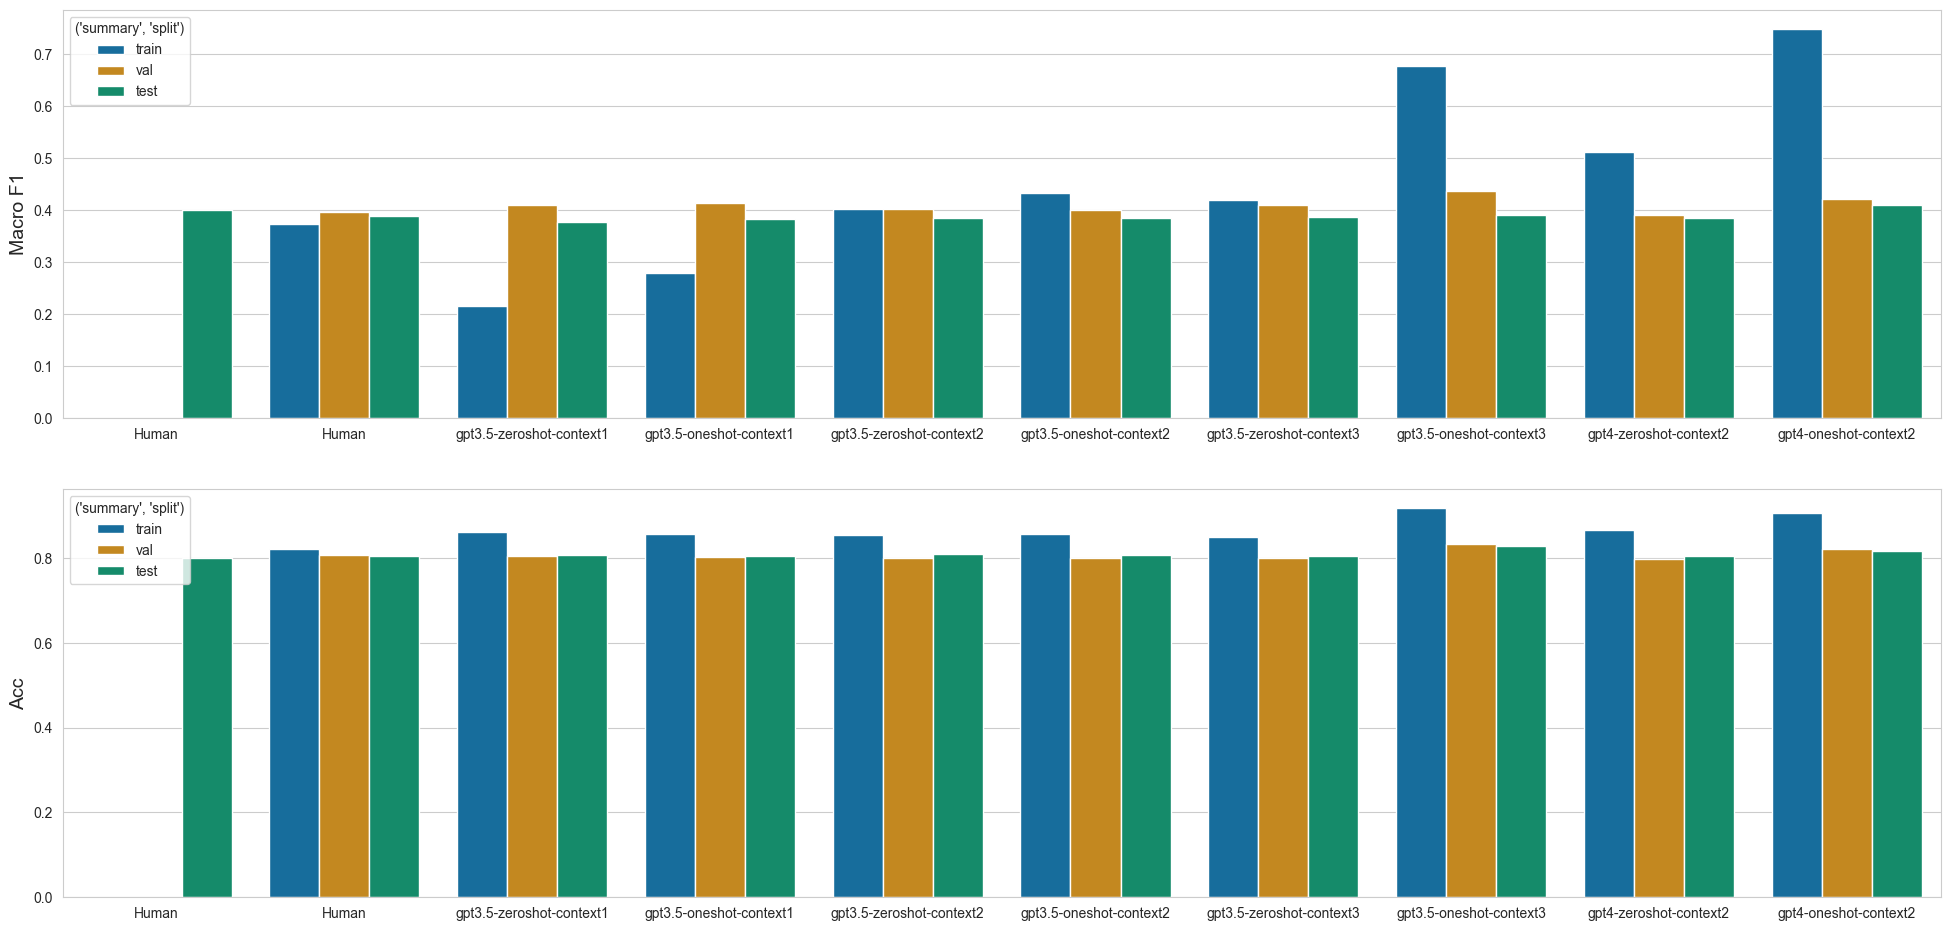

In [15]:
# Pivot dataframe
pivoted_exp1_best_runs_df = pivot_df(exp1_best_runs_df)
fig, axs = plt.subplots(nrows=2, figsize=(20, 10))
fig.tight_layout(pad=3.0)

metrics = ["f1", "acc"]
for ax, metric in zip(axs, metrics):
    sns.barplot(
        data=pivoted_exp1_best_runs_df,
        x=("config", "name"),
        y=("summary", metric),
        hue=("summary", "split"),
        ax=ax
    )

    run_names = [x.get_text() for x in ax.get_xticklabels()]
    rows = [pivoted_exp1_best_runs_df[pivoted_exp1_best_runs_df[("config", "name")] == run_name].iloc[0] for run_name in run_names]
    xtick_labels = [rename(row[("config", "train_labeler_name")]) for row in rows]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel("")
    ax.set_ylabel(rename(metric), fontsize=14)

path = os.path.join(FIGURE_DIR, "exp1-splits.pdf")
fig.savefig(path, dpi=300, bbox_inches="tight")
print(f"✅ Saved figure to {path}")

### Category-wise performance

In [16]:
from sklearn.metrics import classification_report


def get_test_cm(run: Run) -> pd.DataFrame:
    """
    Extracts the test confusion matrix from a run.
    """
    test_cm = json.loads(run.summary.get("test/cm", None))
    if test_cm is None:
        return None
    test_cm = pd.DataFrame.from_dict(test_cm)
    test_cm["category"].replace(idx2categories, inplace=True)
    test_cm.set_index("category", inplace=True)
    return test_cm

def get_test_report(run: Run) -> pd.DataFrame:
    """
    Extracts the test report from a run.
    """
    test_report = json.loads(run.summary.get("test/report", None))
    if test_report is None:
        return None
    test_report = pd.DataFrame.from_dict(test_report)
    mapper_ = {str(idx): category for idx, category in idx2categories.items()}
    test_report["category"] = test_report["category"].map(lambda x: mapper_.get(x, x))
    return test_report

def get_test_targets(run: Run) -> pd.DataFrame:
    """
    Extracts the test predictions from a run.
    """
    test_targets = json.loads(run.summary.get("test/targets"))
    return pd.DataFrame(test_targets, columns=categories)

def get_test_preds(run: Run) -> pd.DataFrame:
    """
    Extracts the test predictions from a run.
    """
    test_preds = json.loads(run.summary.get("test/preds"))
    return pd.DataFrame(test_preds, columns=categories)

def get_test_probs(run: Run) -> pd.DataFrame:
    """
    Extracts the test probabilities from a run.
    """
    test_probs = json.loads(run.summary.get("test/probs"))
    return pd.DataFrame(test_probs, columns=categories)

In [17]:
def get_test_reports_df(runs: list[Run]) -> pd.DataFrame:
    test_reports_df = pd.DataFrame()
    for run in runs:
        run_config = extract_config(run)
        test_report = get_test_report(run)

        for k, v in run_config.items():
            test_report[k] = v

        # Concatenate
        test_reports_df = pd.concat([test_reports_df, test_report])

    return test_reports_df

In [18]:
# fig, axs = plt.subplots(nrows=3, figsize=(20, 10))
# subset = exp1_test_reports_df[exp1_test_reports_df["train_labeler_name"] == "human"]
# metrics = ["precision", "recall", "f1-score"]
# for ax, metric in zip(axs, metrics):
#     sns.barplot(
#         data=subset,
#         x="category",
#         y=metric,
#         hue="finetune",
#         ax=ax
#     )

## Experiment 2: Fine-tuning on `curlie-10000`

In [19]:
# Filter runs for Experiment 2
GROUP = "exp2-2"

exp2_runs = [run for run in runs if run.group == GROUP]

print(f"✅ Loaded {len(exp2_runs)} runs from W&B ({WANDB_ENTITY}/{WANDB_PROJECT} - {GROUP})")

✅ Loaded 21 runs from W&B (ml-project-2-mlp/homepage2vec - exp2-2)


In [20]:
# Convert to dataframe
exp2_runs_df = runs_to_df(exp2_runs)
exp2_best_runs_df = best_runs(exp2_runs_df)

# Show best runs by F1
exp2_best_runs_df.sort_values(("summary", "test/f1"), ascending=False)

config                                            \
                     name finetune train_ratio val_ratio test_ratio   
izcyfryc  royal-smoke-381     True         1.0       0.3        0.7   
re5j59qh   hearty-eon-362    False         0.6       0.3        0.7   

                                                                  \
         train_data_name test_data_name       train_labeler_name   
izcyfryc          curlie       original  gpt3.5-oneshot-context2   
re5j59qh        original       original                    human   

                             hparams  ...     summary            \
         test_labeler_name        lr  ... val/f1_best  test/acc   
izcyfryc             human  0.000067  ...     0.41718  0.787590   
re5j59qh             human  0.000100  ...         NaN  0.798311   

                                                             \
                                                 test/probs   
izcyfryc  [[0.5203351378440857, 0.4294857680797577, 0.57...   
re5j59qh  [[0.024753907695412636, 0.08777373284101486, 0...   

                                                                       \
                                               test/targets  val/loss   
izcyfryc  [[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [...  2.567213   
re5j59qh  [[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [...       NaN   

                                                             
         test/loss test/precision epoch   test/f1  train/f1  
izcyfryc  2.606695       0.401902    52  0.426289  0.505705  
re5j59qh  3.253315       0.409685     0  0.391610       NaN  

[2 rows x 31 columns]

In [21]:
# Extract best runs
pretrained_runs = exp2_best_runs_df[exp2_best_runs_df[("config", "finetune")] == False]
finetuned_runs = exp2_best_runs_df[exp2_best_runs_df[("config", "finetune")] == True]

pretrained_run_ids = pretrained_runs.index.values
finetuned_run_ids = finetuned_runs.index.values

pretrained_runs = [run for run in exp2_runs if run.id in pretrained_run_ids]
finetuned_runs = [run for run in exp2_runs if run.id in finetuned_run_ids]

print(f"Got {len(pretrained_runs)} pretrained run(s) and {len(finetuned_runs)} finetuned run(s) for {GROUP}")

Got 1 pretrained run(s) and 1 finetuned run(s) for exp2-2


In [22]:
# Get best runs
pretrained_run = pretrained_runs[0]
finetuned_run = finetuned_runs[0]

pretrained_cms = get_test_cm(pretrained_run)
finetuned_cms = get_test_cm(finetuned_run)

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures/exp2-mf1.pdf


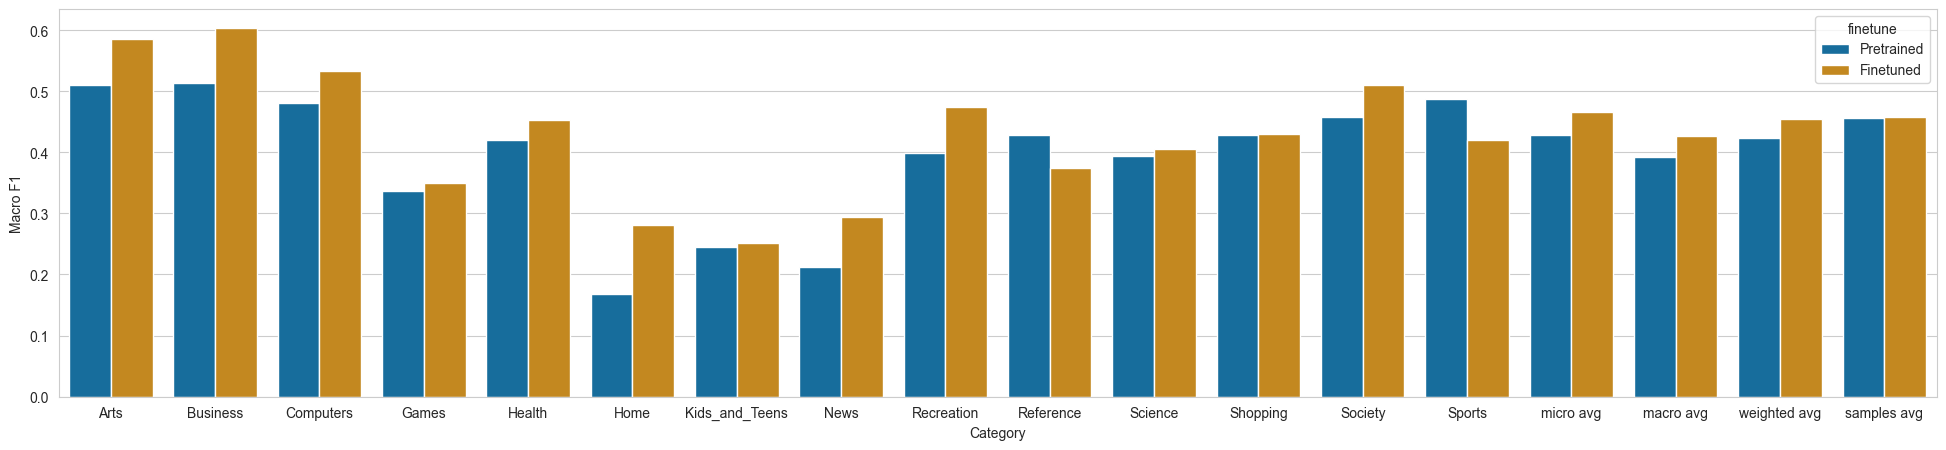

In [23]:
# Visualise the macro F1
pretrained_report = get_test_report(pretrained_run)
finetuned_report = get_test_report(finetuned_run)

pretrained_report["finetune"] = "Pretrained"
finetuned_report["finetune"] = "Finetuned"

test_reports = pd.concat([pretrained_report, finetuned_report])

fig, ax = plt.subplots(figsize=(20, 5))
fig.tight_layout(pad=3.0)
sns.barplot(
    data=test_reports,
    x="category",
    y="f1-score",
    hue="finetune",
    ax=ax
)
ax.set_xlabel("Category")
ax.set_ylabel("Macro F1")

# Save figure
path = os.path.join(FIGURE_DIR, "exp2-mf1.pdf")
fig.savefig(path, bbox_inches="tight")
print(f"✅ Saved figure to {path}")

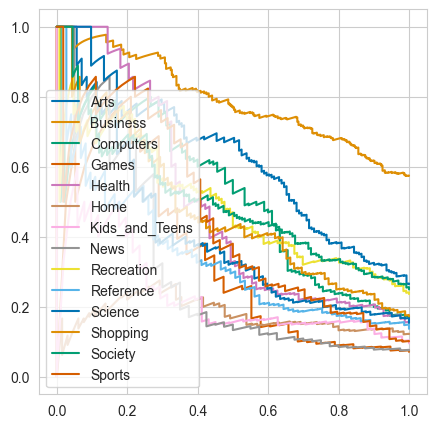

In [35]:
# Visualise the precision-recall curve
fig, ax = plt.subplots(figsize=(5, 5))
y_test, y_prob = get_test_targets(finetuned_run), get_test_probs(finetuned_run)
y_test, y_prob = y_test.values, y_prob.values
for k in range(14):
    pr, re, th = precision_recall_curve(y_test[:, k], y_prob[:, k])
    ax.plot(re, pr, label=idx2categories[k])
ax.legend()

In [ ]:
# Visualise the confusion matrices for the best runs
fig, axs = plt.subplots(nrows=2, ncols=14, figsize=(4*14, 3*2))
for i, (_, pretrained_cm) in enumerate(pretrained_cms.iterrows()):
    sns.heatmap(
        [[pretrained_cm["tn"], pretrained_cm["fp"]], [pretrained_cm["fn"], pretrained_cm["tp"]]],
        ax=axs[0][i]
    )
    axs[0][i].set_title(pretrained_cm.name)
    axs[0][i].set_xlabel("Predicted")
    if i > 0:
        axs[0][i].set_yticks([])
        axs[0][i].set_ylabel("")

for i, (_, pretrained_cm) in enumerate(finetuned_cms.iterrows()):
    sns.heatmap(
        [[pretrained_cm["tn"], pretrained_cm["fp"]], [pretrained_cm["fn"], pretrained_cm["tp"]]],
        ax=axs[1][i]
    )
    axs[1][i].set_xlabel("Predicted")
    if i > 0:
        axs[1][i].set_yticks([])
        axs[1][i].set_ylabel("")

axs[0][0].set_ylabel("Actual", fontsize=14)
axs[0][1].set_ylabel("Actual", fontsize=14)

path = os.path.join(FIGURE_DIR, "exp2-cms.pdf")
fig.savefig(path, bbox_inches="tight")
print(f"✅ Saved figure to {path}")

In [ ]:
# Pivot dataframe
pivoted_exp2_best_runs_df = pivot_df(exp2_best_runs_df)
fig, axs = plt.subplots(nrows=2, figsize=(20, 10))
fig.tight_layout(pad=3.0)

metrics = ["f1", "acc"]
for ax, metric in zip(axs, metrics):
    sns.barplot(
        data=pivoted_exp2_best_runs_df,
        x=("config", "name"),
        y=("summary", metric),
        hue=("summary", "split"),
        ax=ax
    )

    run_names = [x.get_text() for x in ax.get_xticklabels()]
    rows = [pivoted_exp2_best_runs_df[pivoted_exp2_best_runs_df[("config", "name")] == run_name].iloc[0] for run_name in run_names]
    xtick_labels = [rename(row[("config", "train_labeler_name")]) for row in rows]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel("")
    ax.set_ylabel(rename(metric), fontsize=14)

path = os.path.join(FIGURE_DIR, "exp1-splits.pdf")
fig.savefig(path, dpi=300, bbox_inches="tight")
print(f"✅ Saved figure to {path}")